In [13]:
import os
os.chdir('../../')

In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import mlp,cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split

In [15]:
# X,Y =  make_circles(noise=0, factor=0.5, random_state=1,n_samples=200)

In [16]:
X,Y =  datasets.make_moons(200, noise=0.2)

X.shape,Y.shape

((200, 2), (200,))

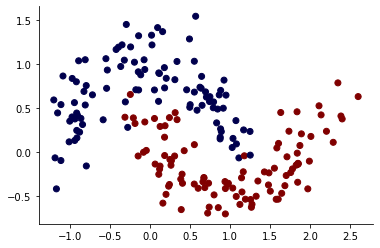

In [17]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap='seismic')
sns.despine()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [19]:
model = cmlp.mlp([64,48,16,1],[nn.relu,nn.relu,nn.relu],[0,0,0])


In [20]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}


In [25]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.01, epochs=50, verbose=True)

Loss step 0:  0.71741027
Loss step 5:  0.4233642
Loss step 10:  0.34959078
Loss step 15:  0.31839347
Loss step 20:  0.29391113
Loss step 25:  0.26488933
Loss step 30:  0.22573626
Loss step 35:  0.17320938
Loss step 40:  0.11554323
Loss step 45:  0.07585904


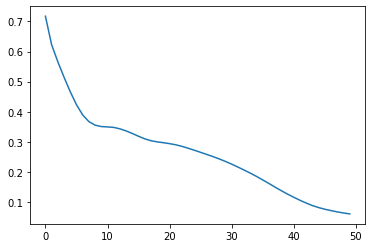

In [26]:
plt.plot(jnp.arange(0,50,1),loss)

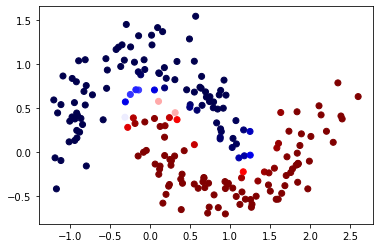

In [27]:
y_pred=model.apply(params,X_train,deterministic=True)
y_pred_  = y_pred*(1-y_pred)

y_pred_train_single=y_pred.reshape(134)
y_pred_test_single = model.apply(params,X_test,deterministic=True).reshape(66)
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred_test_single,cmap='seismic')
plt.scatter(X_train[:,0],X_train[:,1],c=y_pred,cmap='seismic')




In [28]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_train,y_pred_train_single),brier_score_loss(y_test,y_pred_test_single)


(0.017232372758037174, 0.014638361795567448)

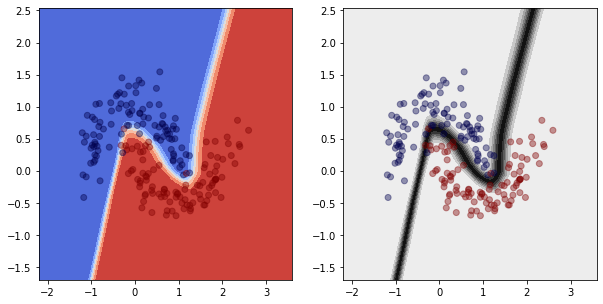

In [29]:
h=0.02
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))
Z =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True)
Z_ = Z*(1-Z)
Z= Z.reshape(xx.shape)
Z_= Z_.reshape(xx.shape)
ax2.contourf(xx, yy, Z_,cmap='binary')
ax1.contourf(xx, yy, Z,cmap='coolwarm')
# fig.colorbar()

ax1.scatter(X[:,0],X[:,1],c=Y,alpha=0.4,cmap='seismic')
ax2.scatter(X[:,0],X[:,1],c=Y,alpha=0.4,cmap='seismic')
# plt.ylim(-1.2,1.4)

In [35]:
params_lst= []
loss_lst =[]

for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params, auxs, learning_rate=0.01, epochs=45, verbose=False)
    params_lst.append(params)
    loss_lst.append(loss)

    

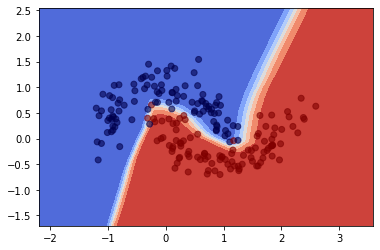

In [50]:
y_pred_grid_ensemble = []
for i in range(5):
    y_pred = model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True)
    y_pred_grid_ensemble.append(y_pred)
pred = jnp.array(y_pred_grid_ensemble).mean(axis=0)
sigma =  jnp.array(y_pred_grid_ensemble).std(axis=0)

Z = pred.reshape(xx.shape)
Z_ = pred*(1-pred)
Z__ = Z+sigma.reshape(xx.shape)

Z_= Z_.reshape(xx.shape)
plt.contourf(xx, yy, Z__,cmap='coolwarm')
plt.scatter(X[:,0],X[:,1],c=Y,alpha=.6,cmap='seismic')
# plt.ylim(-1.2,1.3)


In [37]:
y_pred_train_ensemble = []
y_pred_test_ensemble = []
for i in range(5):
    y_pred_ = model.apply(params_lst[i],X_train,deterministic=True)
    y_pred_t = model.apply(params_lst[i],X_test,deterministic=True)

    y_pred_train_ensemble.append(y_pred_)
    y_pred_test_ensemble.append(y_pred_t)
y_pred_train_ensemble = jnp.array(y_pred_train_ensemble).mean(axis=0)

y_pred_test_ensemble = jnp.array(y_pred_test_ensemble).mean(axis=0)


In [38]:
brier_score_loss(y_train,y_pred_train_ensemble),brier_score_loss(y_test,y_pred_test_ensemble)

(0.01881693943092934, 0.012444640729482311)

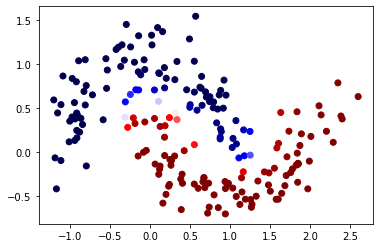

In [39]:
y_pred_train_ensemble=y_pred_train_ensemble.reshape(134)
y_pred_test_single =y_pred_test_ensemble.reshape(66)
plt.scatter(X_test[:,0],X_test[:,1],c=y_pred_test_ensemble,cmap='seismic')
plt.scatter(X_train[:,0],X_train[:,1],c=y_pred_train_ensemble,cmap='seismic')
